# Classificação usando Árvore de Decisão


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas e referências usadas

- scikit-learn
  - sklearn.tree
    - [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    - [Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)
  - sklearn.model_selection
    - train_test_split
    - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  - sklearn.metrics
    - accuracy_score
    - [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
    - [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
    - confusion_matrix
    - [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
- pandas
- numpy
- matplotlib

## Importando dependências

In [2]:
from google.colab import files
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from numpy import unique
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Importando os datasets

### Dataset de treinamento: avila-tr.txt

In [3]:
# labels das features
labels = ["intercolumnar distance","upper margin","lower margin","exploitation","row number","modular ratio","interlinear spacing","weight","peak number","modular ratio/ interlinear spacing","Class"]
# labels das classes
classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "W", "X", "Y"]

path_dataset_train = "/content/drive/MyDrive/Disciplinas/2022.2/AM-GRAD 2022-2/Projeto AM 2022-2/data/avila-tr.txt"

avila_train = pd.read_csv(path_dataset_train, sep=",",header=None,names=labels)
avila_train.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


### Dataset de teste: avila-ts.txt

In [4]:
path_dataset_test = "/content/drive/MyDrive/Disciplinas/2022.2/AM-GRAD 2022-2/Projeto AM 2022-2/data/avila-ts.txt"

avila_test = pd.read_csv(path_dataset_test, sep=",",header=None,names=labels)
avila_test.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A


## Setando a seed do gerador de números aleatórios


- Dessa forma os resultados obtidos pelo modelo não serão diferentes para diferentes sessões

In [5]:
SEED = 32642
np.random.seed(SEED)

## Dividindo dataset de treinamento e teste em: features e classes

In [6]:
# Features de treinamento
X_train = avila_train.drop(['Class'], axis = 1)

# Classes de treinamento
y_train = avila_train['Class']

print("Dataset de treinamento")
print("Tamanho do dataset de features = ", X_train.shape)
print("Tamanho do dataset de classes = ", y_train.shape)

Dataset de treinamento
Tamanho do dataset de features =  (10430, 10)
Tamanho do dataset de classes =  (10430,)


In [7]:
# Features de teste
X_test = avila_test.drop(['Class'], axis = 1)

# Classes de teste
y_test = avila_test['Class']

print("Dataset de teste")
print("Tamanho do dataset de features = ", X_test.shape)
print("Tamanho do dataset de classes = ", y_test.shape)

Dataset de teste
Tamanho do dataset de features =  (10437, 10)
Tamanho do dataset de classes =  (10437,)


## Modelo padrão de árvore de decisão

Treinaremos o modelo usando o parâmetro de random_state com o valor da SEED.

Após isso, obteremos os resultados preditos do treinamento usando o dataset de teste.

In [8]:
dtc = DecisionTreeClassifier(random_state = SEED)
dtc.fit(X_train, y_train)

predicted = dtc.predict(X_test)
predicted

array(['W', 'A', 'A', ..., 'A', 'F', 'H'], dtype=object)

Obtivemos nosso array de predições, agora, vamos analisar quantos desses resultados nosso modelo acertou.

### Análises

#### Resultados numéricos:

- Para cada classe:
  - Precisão
  - Recall
  - F1 Score
- Acurácia
- Médias macro e weighted:
  - Precisão
  - Recall
  - F1 Score

Com o classification_report, comparamos o array de elementos preditos com o array dos elementos reais do dataset de teste.

In [9]:
cr = classification_report(predicted, y_test, digits=4)

print(f'Classification report: \n{cr}')

Classification report: 
              precision    recall  f1-score   support

           A     0.9809    0.9800    0.9804      4290
           B     1.0000    1.0000    1.0000         5
           C     0.9806    0.9528    0.9665       106
           D     0.9717    0.9608    0.9662       357
           E     0.9443    0.9478    0.9460      1091
           F     0.9745    0.9795    0.9770      1952
           G     0.9620    0.9685    0.9652       444
           H     0.9635    0.9364    0.9498       535
           I     0.9832    0.9855    0.9844       830
           W     0.9556    0.8431    0.8958        51
           X     0.9176    0.9283    0.9229       516
           Y     0.9288    0.9538    0.9412       260

    accuracy                         0.9694     10437
   macro avg     0.9635    0.9530    0.9580     10437
weighted avg     0.9695    0.9694    0.9694     10437



Resultados para cada classe:
- Percebemos uma boa média geral nos valores do Precision Score, com todas acima de 0.9, ressaltando o resultado perfeito para a classe "B", que por possuir somente 5 instâncias tanto no dataset de treino quanto no dataset de teste, acabou garantindo esse resultado.
- Para os resultados de Recall Score e F1-Score, os resultados foram semelhantes aos do Precision Score, exceto para a classe "W" que obteve resultados abaixo de 0.9, provavelmente, por uma alta quantidade de Falsos Negativos no cálculo.

Resultados gerais:
- Obtivemos uma acurácia satisfatória de ~0.97.
- Também obtivemos médias satisfatórias de Precision = ~0.96, Recall = ~0.95 e F1-Score = ~0.96.

#### Matriz de confusão

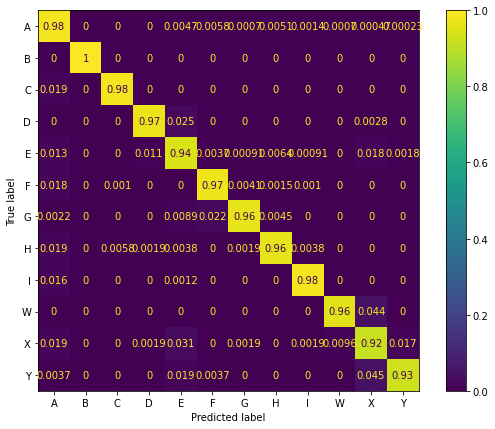

In [10]:
cm = confusion_matrix(y_test, predicted, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

Pela nossa matriz, percebemos visualmente os resultados obtidos pelo nosso modelo. Todos resultados satisfatórios.

## Otimização do modelo usando GridSearchCV


Código de referência: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Parâmetros que atualizaremos no GridSearchCV para o DecisionTreeClassifier:
- criterion: função que mede a qualidade do split dos nós.
  - gini: para a Gini impurity;
  - log_loss e entropy: ambos para o ganho de informação Shannon.
- splitter: estratégia usada para separar cada nó.
  - best: escolhe o melhor split;
  - random: escolhe o melhor split aleatório.
- max_depth: profundidade máxima da árvore.
- max_leaf_nodes: quantidade máxima de folhas.
  - None: ilimitado.
- ccp_alpha: custo de complexidade que permite realizar um método de poda da árvore, o Minimal Cost-Complexity Pruning. A sub-árvore com o maior custo de complexidade que é menor que ccp_alpha será escolhida.
  - 0.0: sem poda.
- random_state: controla a aleatoriedade do estimador.
  - Usaremos a nossa Seed setada previamente.

O GridSearchCV também possui integrado um Cross-Validation, através do parâmetro cv.
- Usaremos 5 folds para o Cross-Validation do modelo, assim permitindo com que pelo menos um elemento da classe B fique em cada fold.

In [11]:
dtc = DecisionTreeClassifier()

params = {'criterion':['gini', 'entropy', 'log_loss'], 
          'splitter':['best','random'],
          'max_depth':[None, 2, 5, 10, 15, 20],
          'ccp_alpha':[0.0, 0.0000001, 0.00001, 0.001, 0.01, 0.1, 0.5, 0.75],
          'random_state': [SEED]}

gs_dtc = GridSearchCV(dtc, params, cv=5, refit=True)

In [12]:
gs_dtc.fit(X_train, y_train)
gs_dtc.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': None,
 'random_state': 32642,
 'splitter': 'best'}

In [13]:
best_dtc = DecisionTreeClassifier()

best_dtc.set_params(**gs_dtc.best_params_)

best_dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=32642)

In [14]:
best_predicted = best_dtc.predict(X_test)
best_predicted

array(['W', 'A', 'I', ..., 'A', 'F', 'H'], dtype=object)

### Análises do melhor modelo do GridSearchCV

#### Resultados de teste:

- Para cada classe:
  - Precisão
  - Recall
  - F1 Score
- Acurácia
- Médias macro e weighted:
  - Precisão
  - Recall
  - F1 Score

In [15]:
cr = classification_report(best_predicted, y_test, digits=4)

print(f'Classification report: \n{cr}')

Classification report: 
              precision    recall  f1-score   support

           A     0.9944    0.9949    0.9946      4284
           B     1.0000    1.0000    1.0000         5
           C     0.9806    0.9712    0.9758       104
           D     0.9688    0.9942    0.9813       344
           E     0.9781    0.9649    0.9714      1110
           F     0.9975    0.9924    0.9949      1972
           G     0.9508    0.9907    0.9703       429
           H     0.9788    0.9770    0.9779       521
           I     0.9988    1.0000    0.9994       831
           W     1.0000    0.9574    0.9783        47
           X     0.9579    0.9470    0.9524       528
           Y     0.9700    0.9885    0.9792       262

    accuracy                         0.9875     10437
   macro avg     0.9813    0.9815    0.9813     10437
weighted avg     0.9876    0.9875    0.9875     10437



#### Matriz de confusão

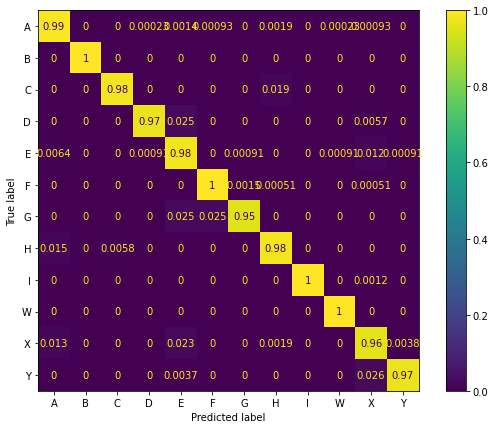

In [16]:
cm = confusion_matrix(y_test, best_predicted, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

# Classificação usando Regressão Logística


## Bibliotecas usadas:
- scikit-learn (LogisticRegression)
  - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- pandas

O primeiro ponto importante a ser notado é que o problema em questão é de classificação multi-classe. O algoritmo de regressão logística consegue separar um dado entre 2 classes, tal como um problema de sim ou não. Assim, para um problema multi-classe, podemos tratar cada classe como um problema de classificação binária, ou seja, vamos comparar, para cada classe, se um dado pertence a ela ou não. Essa abordagem é conhecida como "método de um contra todos". Nessa abordagem, ao trabalharmos com uma classe, essa classe é denotada por 1 e as outras, por 0.

## Modelo base

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5309954967902654

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.50      0.97      0.66      4286
           B       1.00      1.00      1.00         5
           C       0.00      0.00      0.00       103
           D       0.00      0.00      0.00       353
           E       0.40      0.07      0.12      1095
           F       0.19      0.03      0.05      1962
           G       0.00      0.00      0.00       447
           H       0.47      0.08      0.13       520
           I       0.82      0.88      0.85       832
           W       0.00      0.00      0.00        45
           X       0.82      0.67      0.74       522
           Y       0.74      0.47      0.58       267

    accuracy                           0.53     10437
   macro avg       0.41      0.35      0.34     10437
weighted avg       0.43      0.53      0.42     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


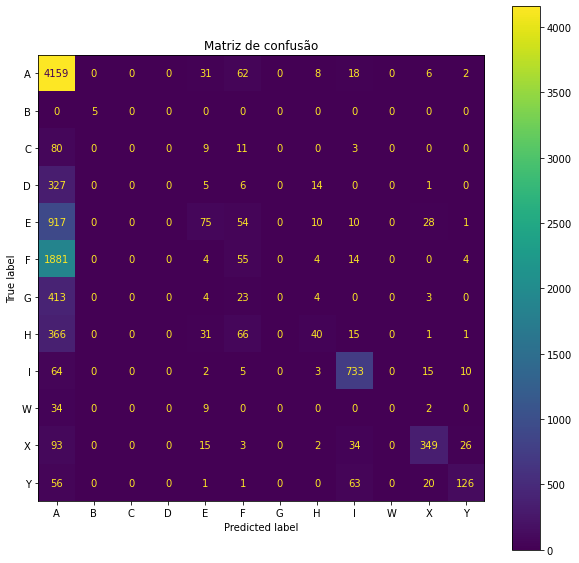

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Não tivemos uma boa acurácia. Para buscar os melhores parâmetros, vamos usar um grid search com cross validation.

O modelo de regressão logística não é adequado para o teste nesse dataset. Isso acontece por alguns motivos, dentre os quais estão o desbalanceamento do dataset e a proximidade dos exemplos do dataset. Levando em conta esses 2 fatores, pode-se inferir que modelos que possuam uma avaliação discreta das features, tal como a árvore de decisão, devem performar melhor que a regressão logística, a qual utiliza os valores das features para calcular um valor entre 0 e 1 e também utiliza um threshold para realizar a classificação.

## Grid search

In [ ]:
parameters = {'multi_class': ["ovr", "multinomial"], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}
log_reg = LogisticRegression(max_iter=1000, random_state=SEED)
log_reg_cv = GridSearchCV(estimator=log_reg, param_grid=parameters, cv=5, n_jobs=-1, scoring=['precision_macro','recall_macro','f1_macro'], refit=False)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=32642),
             n_jobs=-1,
             param_grid={'multi_class': ['ovr', 'multinomial'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             refit=False,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

In [ ]:
results_df = pd.DataFrame(log_reg_cv.cv_results_)
results_df[['mean_test_f1_macro','mean_test_recall_macro','mean_test_precision_macro', 'params']].head()

,mean_test_f1_macro,mean_test_recall_macro,mean_test_precision_macro,params
0,0.337121,0.345924,0.403675,"{'multi_class': 'ovr', 'solver': 'lbfgs'}"
1,0.337121,0.345924,0.403675,"{'multi_class': 'ovr', 'solver': 'newton-cg'}"
2,0.263750,0.266564,0.343546,"{'multi_class': 'ovr', 'solver': 'sag'}"
3,0.247812,0.253806,0.334808,"{'multi_class': 'ovr', 'solver': 'saga'}"
4,0.398664,0.398872,0.464567,"{'multi_class': 'multinomial', 'solver': 'lbfgs'}"


Analisando a tabela, é possível identificar que os melhores parâmetros são "multinomial" para "multi_class" e "lbfgs" para "solver. Vamos treinar um modelo base utilizando-os.

## Modelo com melhores parâmetros

Utilizando os melhores parâmetros testados pelo grid search, temos "multi_class" como "multinomial", o que significa que o algoritmo de treinamento usará "cross-entropy loss", e o parâmetro "solver" como "lbfgs".

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5613682092555332

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A       0.53      0.94      0.68      4286
           B       1.00      1.00      1.00         5
           C       0.00      0.00      0.00       103
           D       0.00      0.00      0.00       353
           E       0.53      0.25      0.34      1095
           F       0.37      0.09      0.15      1962
           G       0.00      0.00      0.00       447
           H       0.47      0.18      0.26       520
           I       0.85      0.87      0.86       832
           W       0.22      0.04      0.07        45
           X       0.75      0.71      0.73       522
           Y       0.70      0.64      0.67       267

    accuracy                           0.56     10437
   macro avg       0.45      0.39      0.40     10437
weighted avg       0.49      0.56      0.48     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


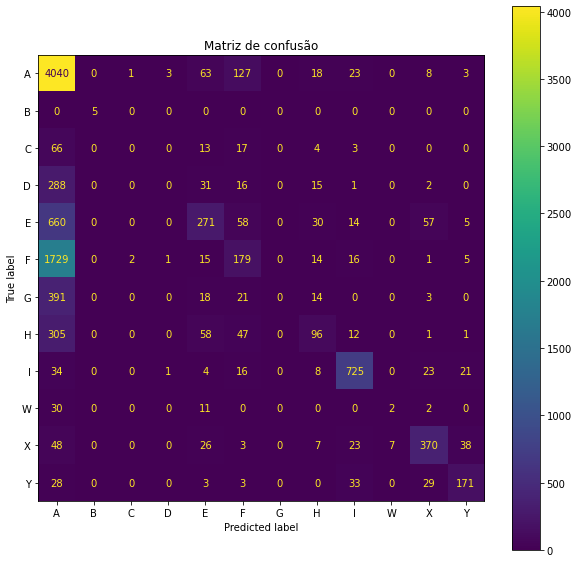

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Foi possível perceber que o modelo base errou todos das classes C, D e G, além de ter errado a maioria dos exemplos das classes E, F, H e W. Além disso, um fato muito interessante de se notar é que todas essas classes que não tiveram bons resultados foram confundidas com exemplos da classe A. Isso provavelmente aconteceu devido ao desbalanceamento do dataset, com muito mais dados da classe A. Assim, para a primeira tentativa de melhoria do modelo, vamos apenas diminuir a quantidade de exemplos da classe A e manter os outros parâmetros.

## Modelo com mudança no balanceamento do dataset

Para este modelo, vamos reduzir o número de exemplos da classe A.

In [ ]:
# Mudanças no dataset
balanced_dataset = avila_train.drop(avila_train.query("Class == 'A'").sample(frac=0.5).index)
balanced_dataset.shape

X_train_balanced = balanced_dataset.iloc[:, :-1]
y_train_balanced = balanced_dataset.iloc[:, -1]

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5474753281594328

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.65      0.62      0.63      4286
           B       1.00      1.00      1.00         5
           C       0.00      0.00      0.00       103
           D       0.00      0.00      0.00       353
           E       0.49      0.44      0.46      1095
           F       0.34      0.61      0.44      1962
           G       0.00      0.00      0.00       447
           H       0.49      0.21      0.29       520
           I       0.84      0.87      0.86       832
           W       0.14      0.04      0.07        45
           X       0.71      0.71      0.71       522
           Y       0.69      0.65      0.67       267

    accuracy                           0.55     10437
   macro avg       0.45      0.43      0.43     10437
weighted avg       0.53      0.55      0.53     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


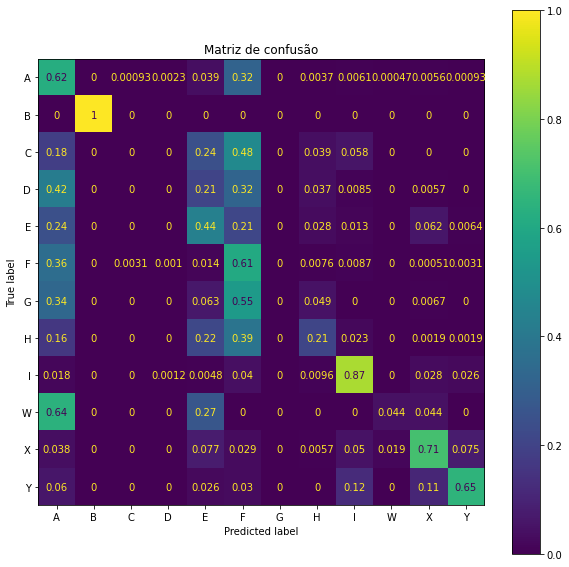

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

O resultado da classificação melhorou muito para algumas das classes, como a E e a F, mas ele piorou para a classe A. Observando as matrizes de confusão dos dois modelos testados até aqui, é possível inferir que as classes A e F estão gerando muitos problemas para a classificação. Isso pode estar acontecendo porque ambas as classes devem possuir exemplos muito próximos uns dos outros, dificultando sua separação. Vamos utilizar a técnica do PCA para identificar as features que melhor separam ambas as classes e utilizá-las para realizar a classificação.

## Modelo com mudança nas colunas do dataset

Inicialmente vamos tentar procurar formas de separar as classes A e F, a fim de melhorar a acurácia do modelo. Para isso, vamos tentar utilizar o PCA.

In [ ]:
avila_tr_A = avila_train.query("Class == 'A'")
avila_tr_F = avila_train.query("Class == 'F'")
avila_tr_A_F = pd.concat([avila_tr_A, avila_tr_F], axis=0)
avila_tr_A_F.shape

X_train_A_F = avila_tr_A_F.iloc[:, :-1]
y_train_A_F = avila_tr_A_F.iloc[:, -1].head()

### Análise utilizando PCA

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F)
x = principal.transform(X_train_A_F)
x.shape

(6247, 3)

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F)
encoded_labels = le.transform(y_train_A_F)
encoded_labels

array([0, 0, 0, 0, 0])

ValueError: ignored

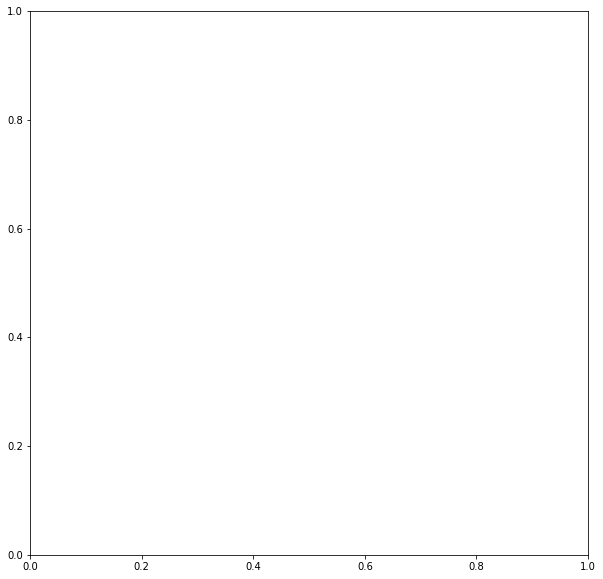

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Utilizando o PCA foi possível ver que, mesmo utilizando os principais componentes para separar os dados, eles ainda não são bem separáveis. Assim, vamos tentar reduzir o número de features, mantendo as mais relevantes de acordo com o artigo que acompanha o projeto.

### Removendo colunas do dataset

In [ ]:
avila_tr_dropped = avila_train.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])
avila_ts_dropped = avila_test.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])

X_train_dropped = avila_tr_dropped.iloc[:, :-1]
y_train_dropped = avila_tr_dropped.iloc[:, -1]

X_test_dropped = avila_ts_dropped.iloc[:, :-1]
y_test_dropped = avila_ts_dropped.iloc[:, -1]

### Análise utilizando PCA para dataset com colunas removidas

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
avila_tr_A_dropped = avila_tr_dropped.query("Class == 'A'")
avila_tr_F_dropped = avila_tr_dropped.query("Class == 'F'")
avila_tr_A_F_dropped = pd.concat([avila_tr_A_dropped, avila_tr_F_dropped], axis=0)

X_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, :-1]
y_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, -1]

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F_dropped)
x = principal.transform(X_train_A_F_dropped)
x.shape

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F_dropped)
encoded_labels = le.transform(y_train_A_F_dropped)
encoded_labels

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [ ]:
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Mesmo com as features menos relevantes removidas, ainda há indecisão na separação, mas vamos testar dessa forma.

### Modelo

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_dropped, y_train_dropped)

### Teste

In [ ]:
model.score(X_test_dropped, y_test_dropped)

In [ ]:
y_pred = model.predict(X_test_dropped)
print(metrics.classification_report(y_test_dropped, y_pred))

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test_dropped, y_pred,normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Não foi possível obter melhorias no modelo removendo algumas colunas, principalmente devido ao desbalanceamento do dataset. Assim, vamos tentar mesclar as abordagens: reduzir o número de casos e remover features menos importantes.

## Modelo com mudança nas colunas e no balanceamento do dataset

Para este modelo, vamos reduzir o número de exemplos das classes A e F e remover as colunas menos relevantes para a classificação.

In [ ]:
# Mudanças no dataset
balanced_dataset = avila_train.drop(avila_train.query("Class == 'A'").sample(frac=0.7).index)
balanced_dataset = balanced_dataset.drop(balanced_dataset.query("Class == 'F'").sample(frac=0.5).index)
balanced_dataset.shape

X_train_balanced = balanced_dataset.iloc[:, :-1]
y_train_balanced = balanced_dataset.iloc[:, -1]

### Análise utilizando PCA

Vamos utilizar o PCA novamente para verificar se o dataset balanceado e com colunas removidas consegue uma melhor separação.

In [ ]:
avila_tr_A = balanced_dataset.query("Class == 'A'")
avila_tr_F = balanced_dataset.query("Class == 'F'")
avila_tr_A_F = pd.concat([avila_tr_A, avila_tr_F], axis=0)

X_train_A_F = avila_tr_A_F.iloc[:, :-1]
y_train_A_F = avila_tr_A_F.iloc[:, -1]

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F)
x = principal.transform(X_train_A_F)
x.shape

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F)
encoded_labels = le.transform(y_train_A_F)
encoded_labels

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Utilizando o PCA foi possível ver que, mesmo utilizando os principais componentes para separar os dados, eles ainda não são bem separáveis. Assim, vamos tentar reduzir o número de features, mantendo as mais relevantes de acordo com o artigo que acompanha o projeto.

### Removendo colunas do dataset

In [ ]:
balanced_dataset_dropped = balanced_dataset.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])
avila_ts_dropped = avila_test.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])

X_train_dropped = balanced_dataset_dropped.iloc[:, :-1]
y_train_dropped = balanced_dataset_dropped.iloc[:, -1]

X_test_dropped = avila_ts_dropped.iloc[:, :-1]
y_test_dropped = avila_ts_dropped.iloc[:, -1]

### Análise utilizando PCA para dataset com colunas removidas

In [ ]:
avila_tr_A_dropped = balanced_dataset_dropped.query("Class == 'A'")
avila_tr_F_dropped = balanced_dataset_dropped.query("Class == 'F'")
avila_tr_A_F_dropped = pd.concat([avila_tr_A_dropped, avila_tr_F_dropped], axis=0)

X_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, :-1]
y_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, -1]

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F_dropped)
x = principal.transform(X_train_A_F_dropped)
x.shape

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F_dropped)
encoded_labels = le.transform(y_train_A_F_dropped)
encoded_labels

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Dessa vez é possível ver um grau um pouco maior de separação, principalmente se considerarmos os exemplos que estão mais distantes do bloco que concentra a maioria dos exemplos.

### Modelo

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_dropped, y_train_dropped)

### Teste

In [ ]:
model.score(X_test_dropped, y_test_dropped)

In [ ]:
y_pred = model.predict(X_test_dropped)
print(metrics.classification_report(y_test_dropped, y_pred))

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test_dropped, y_pred,normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Mesmo com as mudanças, não foi possível melhorar a acurácia. Além disso, com menos exemplos no treinamento, o modelo não conseguiu informações suficientes para classificar A e F, o que também contribuiu para piorar a acurácia.

## Modelo feito manualmente

Para este modelo, vamos programar uma classe para realizar uma avaliação "one vs rest".

In [ ]:
class All_datasets:
  def __init__(self, dataset_tr, dataset_ts):
    self.dataset_tr = dataset_tr
    self.dataset_ts = dataset_ts
    self.classes_tr = self.dataset_tr['Class'].unique()
    self.classes_ts = self.dataset_ts['Class'].unique()
    self.datasets_tr = dict()
    self.datasets_ts = dict()
    self.X_train = dict()
    self.y_train = dict()
    self.X_test = dict()
    self.y_test = dict()
    self.models = dict()
  
  def setup_tr(self):
    for classe in self.classes_tr:
      copied_dataset_tr = self.dataset_tr.copy(deep=True)
      copied_dataset_tr.loc[copied_dataset_tr['Class'] == classe, "Class"] = 1
      copied_dataset_tr.loc[copied_dataset_tr['Class'] != 1, "Class"] = 0
      copied_dataset_tr['Class'] = copied_dataset_tr['Class'].astype(int)
      self.datasets_tr[classe] = copied_dataset_tr
  
  def setup_ts(self): 
    for classe in self.classes_ts:
      copied_dataset_ts = self.dataset_ts.copy(deep=True)
      copied_dataset_ts.loc[copied_dataset_ts['Class'] == classe, "Class"] = 1
      copied_dataset_ts.loc[copied_dataset_ts['Class'] != 1, "Class"] = 0
      copied_dataset_ts['Class'] = copied_dataset_ts['Class'].astype(int)
      self.datasets_ts[classe] = copied_dataset_ts

  def setup(self):
    self.setup_tr()
    self.setup_ts()

  def check_dataset_tr(self, classe):
    print(self.datasets_tr[classe])
  
  def check_dataset_ts(self, classe):
    print(self.datasets_ts[classe])

  def split_train_test(self):
    for classe in self.classes_tr:
      X_train = self.datasets_tr[classe].iloc[:, :-1]
      y_train = self.datasets_tr[classe].iloc[:, -1]
      self.X_train[classe] = X_train
      self.y_train[classe] = y_train

    for classe in self.classes_ts:
      X_test = self.datasets_ts[classe].iloc[:, :-1]
      y_test = self.datasets_ts[classe].iloc[:, -1]
      self.X_test[classe] = X_test
      self.y_test[classe] = y_test

  def create_models(self):
    for classe in self.classes_tr:
      self.models[classe] = LogisticRegression(max_iter=1000, random_state=SEED)
  
  def fit(self):
    for classe in self.classes_tr:
      self.models[classe].fit(self.X_train[classe], self.y_train[classe])
  
  def individual_score(self):
    for classe in self.classes_ts:
      print("Classe {cls} teve score: {scr}".format(cls = classe, scr = self.models[classe].score(self.X_test[classe], self.y_test[classe])))

  def predict(self):
    predicted_probas = dict()
    for classe in self.classes_ts:
      predicted_probas[classe] = []
      class_predict_proba = self.models[classe].predict_proba(self.X_test[classe])
      for prob in class_predict_proba:
        predicted_probas[classe].append(prob[1])

    predicted_list = []
    for i in range(len(predicted_probas["A"])):
      predicted = []
      for classe in self.classes_ts:
        predicted.append((classe, predicted_probas[classe][i]))
      predicted_list.append(predicted)
    
    final_predict = []
    for lst in predicted_list:
      final_predict.append(max(lst, key=lambda item:item[1])[0])
    
    return final_predict


### Modelo

In [ ]:
# Setup do modelo
all_datasets = All_datasets(avila_train, avila_test)
all_datasets.setup()
all_datasets.split_train_test()
all_datasets.create_models()

# Treinamento
all_datasets.fit()

### Teste

In [ ]:
all_datasets.individual_score()

Pelos scores, é possível ver que, ao menos a nível individual, os modelos conseguem diferenciar entre exemplos que pertencem às classes e exemplos que não pertencem, realizando uma avaliação binária.

In [ ]:
all_datasets_pred = all_datasets.predict()
print(metrics.classification_report(y_test, all_datasets_pred))

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, all_datasets_pred, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Ainda que os modelos performem bem em avaliações binárias, o resultado permanece ruim quando eles são unidos. Isso pode ter ligação com a forma escolhida para uni-los, já que ela foi feita escolhendo como classe final aquela que possui maior probabilidade. Além disso, pelos scores individuais, é possível perceber que as classes que possuem mais exemplos (A, E e F) são as que têm menor score, o que indica que o número de casos pode estar introduzindo um viés na classificação dos exemplos.

## Conclusão geral

Ainda que os modelos performem bem em avaliações binárias, o resultado permanece ruim quando eles são unidos. Isso pode ter ligação com a forma escolhida para uni-los, já que ela foi feita escolhendo como classe final aquela que possui maior probabilidade. Além disso, pelos scores individuais, é possível perceber que as classes que possuem mais exemplos (A, E e F) são as que têm menor score, o que indica que o número de casos pode estar introduzindo um viés na classificação dos exemplos.

# Classificação usando kNN

## Bibliotecas usadas:
- scikit-learn
  - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- pandas

## Modelo Base

Antes de tentar encontrar o melhor parâmetro k para o modelo, iremos treinar um modelo mais básico com k=3. Dessa forma, poderemos perceber o ganho de desempenho ocasioando por uma seleção mais cuidadosa do parâmetro.

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
train_score = model_knn.score(X_train,y_train)
test_score  = model_knn.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.8701821668264621
test score:  0.7578806170355467


## Escolhendo os Melhores Parâmetros

 Para alcançar melhores resultados, buscaremos o valor de K que traz os melhores resultados para o modelo. Exploraremos os resultados de F1-Score, Precision e Recall de modelos sobre um conjunto de valores entre 1 e 50. Para essa tarefa, usaremos o GridSearch, que faz uma busca exaustiva no espaço de valores usando validação cruzada, eliminando a necessidade de se separar uma parte do conjunto de treino para realizar a validação do modelo.

In [ ]:
k_values = range(1,50)
scores = ['precision_macro','recall_macro','f1_macro']

In [ ]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': k_values},
    scoring=scores,
    n_jobs=-1,
    refit=False,
    return_train_score=True,
    cv=5
)

gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50)}, refit=False,
             return_train_score=True,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

### Análise

In [ ]:
results_df = pd.DataFrame(gs.cv_results_)

results_df.index = k_values

results_df[['mean_train_f1_macro','mean_test_f1_macro',
            'mean_train_recall_macro','mean_test_recall_macro',
            'mean_train_precision_macro','mean_test_precision_macro']].head()

,mean_train_f1_macro,mean_test_f1_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_precision_macro,mean_test_precision_macro
1,1.000000,0.739940,1.000000,0.720784,1.000000,0.766803
2,0.855714,0.688949,0.813584,0.638692,0.921477,0.780746
3,0.851243,0.709752,0.813864,0.665920,0.897390,0.777080
4,0.815066,0.677423,0.763060,0.627618,0.888523,0.765071
5,0.795160,0.672633,0.743996,0.624549,0.871533,0.756873


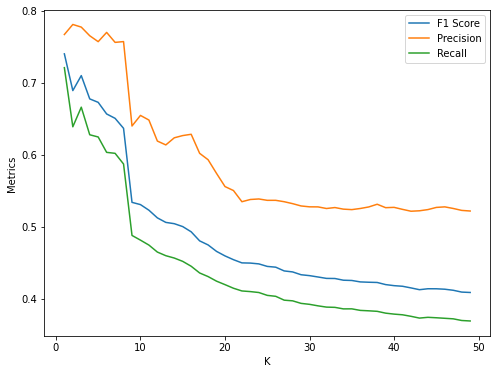

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('K')
ax.set_ylabel('Metrics')

ax.plot(k_values, gs.cv_results_['mean_test_f1_macro'], label='F1 Score')
ax.plot(k_values, gs.cv_results_['mean_test_precision_macro'], label='Precision',)
ax.plot(k_values, gs.cv_results_['mean_test_recall_macro'], label='Recall',)

ax.legend()
plt.show()

 Pelo gráfico acima, percebe-se que todas as métricas se comportam de maneira bastante similar ao longo dos valores de K analisados.
 Percebe-se que os melhores valores de K estão mais à esquerda, sendo aqueles com menor magnitude. É válido ressaltar a queda brusca em todas as métricas que há a no ponto onde K=8. 

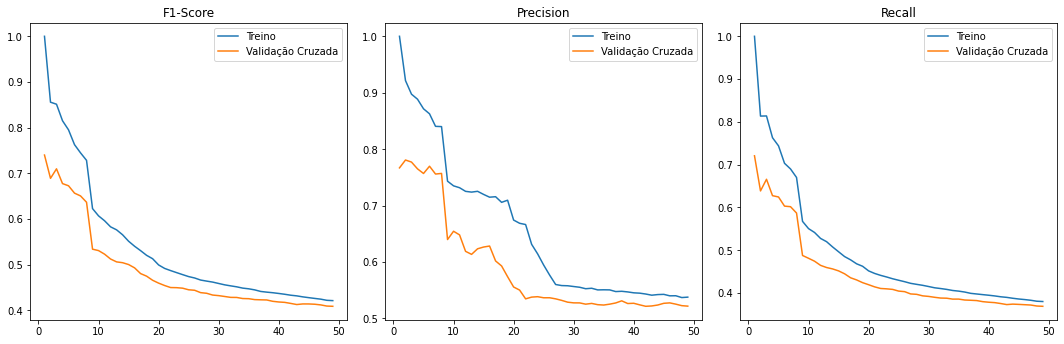

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(k_values,gs.cv_results_['mean_train_f1_macro'])
ax[0].plot(k_values,gs.cv_results_['mean_test_f1_macro'])

ax[1].plot(k_values,gs.cv_results_['mean_train_precision_macro'])
ax[1].plot(k_values,gs.cv_results_['mean_test_precision_macro'])

ax[2].plot(k_values,gs.cv_results_['mean_train_recall_macro'])
ax[2].plot(k_values,gs.cv_results_['mean_test_recall_macro'])

for i in range(0,3):
  ax[i].legend(('Treino','Validação Cruzada'))

ax[0].set_title('F1-Score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

fig.tight_layout(pad=1.5)
plt.show()

Observando os gráficos e a tabela de valores, percebemoes que para o valor K=1, o modelo sofria overffiting uma vez que possuia resultados perfeitos no treinamento. Sendo assim, evitaremos esse valor.

Por fim, percebe-se que o K que produz os melhores resultados, sem causar overffiting é o com K=3. Por coincidência, o mesmo que testamos no modelo base. 

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=3)
best_knn.fit(X_train,y_train)

y_pred = best_knn.predict(X_test)

c_report = classification_report(y_test,y_pred)
print(c_report)

              precision    recall  f1-score   support

           A       0.74      0.86      0.80      4286
           B       1.00      1.00      1.00         5
           C       0.62      0.44      0.51       103
           D       0.74      0.55      0.63       353
           E       0.79      0.65      0.71      1095
           F       0.66      0.67      0.66      1962
           G       0.71      0.53      0.60       447
           H       0.74      0.53      0.62       520
           I       0.97      0.95      0.96       832
           W       1.00      0.60      0.75        45
           X       0.94      0.83      0.88       522
           Y       0.86      0.75      0.80       267

    accuracy                           0.76     10437
   macro avg       0.81      0.70      0.74     10437
weighted avg       0.76      0.76      0.75     10437



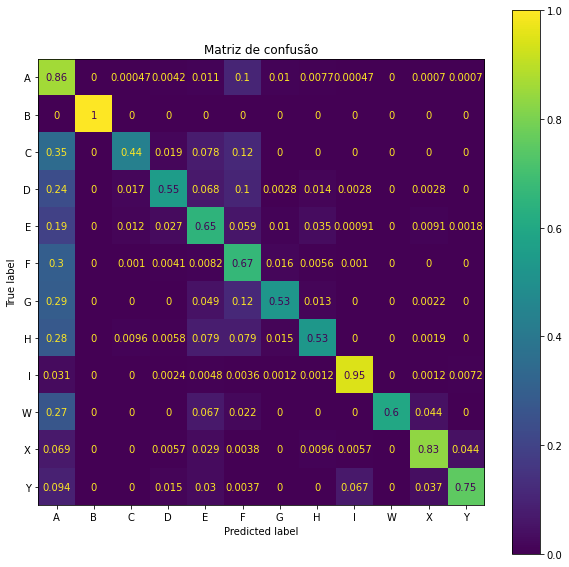

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")

cm = confusion_matrix(y_test, y_pred, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot(ax=ax)
plt.show()


#### Conclusão
 Percebe-se que o KNN obteve uma performance razoável em solucionar o problema. Como pode ser visto na matriz de confusão, o modelo constantemente prediz a classe A, mesmo quando ela não é a correta, provavelmente pelo fato dessa classe possuir a maior quantidade de exmplos.  
 Nota-se também que o modelo se sai melhor em classificar algumas classes do que outras. A classe B tem seus exemplos do teste perfeitamente classificados enquanto que a o modelo falha em classificar exemplos de C mais do que metade das vezes.


# Referências

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search
- https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
- https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c
- https://satishgunjal.com/multiclass_lr_sklearn/#2020
- https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://builtin.com/machine-learning/logistic-regression-classification-algorithm
- https://www.statology.org/pandas-drop-rows-with-condition/
- https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/
- https://towardsdatascience.com/the-perfect-recipe-for-classification-using-logistic-regression-f8648e267592

# Resultados dos modelos

In [ ]:
comparison_dict = {'F1-score': [3, 2, 1, 0], 'Precision': ['a', 'b', 'c', 'd'], 'Recall': ['a', 'b', 'c', 'd'], 'Accuracy': ['a', 'b', 'c', 'd']}

pd.DataFrame.from_dict(comparison_dict, orient='index', columns=["Decision tree", "Logistic regression", "Naive bayes", "KNN"])

,Decision tree,Logistic regression,Naive bayes,KNN
F1-score,3,2,1,0
Precision,a,b,c,d
Recall,a,b,c,d
Accuracy,a,b,c,d


In [ ]:
comparison_dict = {'Decision tree': [3, 2, 1, 0],
                   'Logistic Regression': ['a', 'b', 'c', 'd'],
                   'Naive Bayes': ['a', 'b', 'c', 'd'],
                   'KNN': ['a', 'b', 'c', 'd']}

pd.DataFrame.from_dict(comparison_dict, orient='index',
                       columns=["F1-Score", "Precision", "Recall", "Accuracy"])

,F1-Score,Precision,Recall,Accuracy
Decision tree,3,2,1,0
Logistic Regression,a,b,c,d
Naive Bayes,a,b,c,d
KNN,a,b,c,d
